### 1 : Importing Libraries

In [16]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [17]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [18]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
data = pd.read_csv('data/cleaned_data.csv')

CPU times: user 8 μs, sys: 0 ns, total: 8 μs
Wall time: 20.7 μs


In [19]:
data.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [20]:
# drop the data column as it is not needed for training
data = data.drop(['created_date'], axis=1)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238964 entries, 0 to 238963
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   city_tier               238964 non-null  float64
 1   first_platform_c        238964 non-null  object 
 2   first_utm_medium_c      238964 non-null  object 
 3   first_utm_source_c      238964 non-null  object 
 4   total_leads_droppped    238964 non-null  float64
 5   referred_lead           238964 non-null  float64
 6   app_complete_flag       238964 non-null  int64  
 7   assistance_interaction  238964 non-null  float64
 8   career_interaction      238964 non-null  float64
 9   payment_interaction     238964 non-null  float64
 10  social_interaction      238964 non-null  float64
 11  syllabus_interaction    238964 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 21.9+ MB


### 3 Setting up Environment: 

In [22]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

In [23]:
# import os
# import sqlite3

# # Get current directory (where notebook is running)
# db_dir = os.getcwd()  # this will be '02_training_pipeline/notebooks' if running from the notebook

# # Define DB name and full path
# db_name = 'lead_scoring_model_experimentation.db'
# db_path = os.path.join(db_dir, db_name)

# # Create a connection to the SQLite database
# conn = sqlite3.connect(db_path)

# # Print confirmation
# print(f"Database created at: {db_path}")

# # Close connection
# conn.close()

In [24]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [25]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"

My working mlflow command

mlflow ui   --backend-store-uri="sqlite:///02_training_pipeline/notebooks/lead_scoring_model_experimentation.db"   \
--default-artifact-root="file:///home/CodePro-Lead-Scoring2/02_training_pipeline/notebooks/mlruns"   \
--port=5001

mlflow ui --backend-store-uri="sqlite:///02_training_pipeline/notebooks/lead_scoring_model_experimentation.db" \
--default-artifact-root="file:///home/CodePro-Lead-Scoring2/02_training_pipeline/notebooks/mlruns" \
--port=5001 \
--host=0.0.0.0 \
--gunicorn-opts="--log-level=ERROR" \
2>/dev/null

mlflow ui --port=5001 --host=0.0.0.0

My Mlflow url

https://76a7d32852700.notebooks.jarvislabs.net/proxy/5001/#/experiments/0

In [26]:
# setup pycaret

In [27]:
# # Check mlflow URI
# import mlflow
# print("Tracking URI:", mlflow.get_tracking_uri())
# print("Artifact URI:", mlflow.get_artifact_uri())


In [28]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5001")

In [29]:
from pycaret.classification import *

# Setup with PyCaret 3.3.2 syntax
exp = setup(
    data=data,
    target = 'app_complete_flag',  
    fold_shuffle=True, 
    session_id = 42,
    normalize = True, 
    transformation = True, 
    remove_multicollinearity = True, 
    multicollinearity_threshold = 0.95,
    n_jobs=-1,
    use_gpu=False,
    log_experiment=True,
    # experiment_name='Lead_Scoring_Model_Experimentation',
    log_plots=True,
    log_data=True,
    verbose=True,
    log_profile=False
)

,Description,Value
0,Session id,42
1,Target,app_complete_flag
2,Target type,Binary
3,Original data shape,"(238964, 12)"
4,Transformed data shape,"(238964, 44)"
5,Transformed train set shape,"(167274, 44)"
6,Transformed test set shape,"(71690, 44)"
7,Numeric features,8
8,Categorical features,3
9,Preprocess,True


2025/03/30 23:49:29 INFO mlflow.tracking.fluent: Experiment with name 'clf-default-name' does not exist. Creating a new experiment.


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7381,0.8203,0.8331,0.7014,0.7616,0.4758,0.4845,125.9600
rf,Random Forest Classifier,0.7368,0.8172,0.8201,0.7043,0.7578,0.4733,0.4799,3.0000
et,Extra Trees Classifier,0.7360,0.8160,0.8168,0.7044,0.7565,0.4716,0.4778,3.3100
dt,Decision Tree Classifier,0.7357,0.8152,0.8164,0.7042,0.7562,0.4710,0.4771,1.3280
lr,Logistic Regression,0.7136,0.7897,0.8007,0.6834,0.7373,0.4268,0.4334,1.6940
ridge,Ridge Classifier,0.7098,0.7876,0.8174,0.6740,0.7388,0.4190,0.4289,1.2760
lda,Linear Discriminant Analysis,0.7098,0.7876,0.8174,0.6740,0.7388,0.4190,0.4289,1.4660
nb,Naive Bayes,0.6780,0.7376,0.8509,0.6335,0.7263,0.3551,0.3784,1.5580


### 4 : Model Experimentation with pycaret

In [30]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(sort='AUC', exclude=['gbc', 'knn', 'qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7381,0.8203,0.8331,0.7014,0.7616,0.4758,0.4845,126.5260
rf,Random Forest Classifier,0.7368,0.8172,0.8201,0.7043,0.7578,0.4733,0.4799,2.8820
et,Extra Trees Classifier,0.7360,0.8160,0.8168,0.7044,0.7565,0.4716,0.4778,3.3020
dt,Decision Tree Classifier,0.7357,0.8152,0.8164,0.7042,0.7562,0.4710,0.4771,1.3960
lr,Logistic Regression,0.7136,0.7897,0.8007,0.6834,0.7373,0.4268,0.4334,1.3620
ridge,Ridge Classifier,0.7098,0.7876,0.8174,0.6740,0.7388,0.4190,0.4289,1.2840
lda,Linear Discriminant Analysis,0.7098,0.7876,0.8174,0.6740,0.7388,0.4190,0.4289,1.4080
nb,Naive Bayes,0.6780,0.7376,0.8509,0.6335,0.7263,0.3551,0.3784,1.5620


In [31]:
# create a model which gives the highest accuracy
final_model = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7363,0.8168,0.8327,0.6994,0.7602,0.4722,0.4811
1,0.7369,0.8184,0.8317,0.7004,0.7604,0.4734,0.4820
2,0.7448,0.8269,0.8363,0.7082,0.7669,0.4892,0.4975
3,0.7417,0.8230,0.8356,0.7048,0.7646,0.4830,0.4916
4,0.7393,0.8207,0.8376,0.7012,0.7634,0.4781,0.4875
5,0.7377,0.8218,0.8297,0.7020,0.7605,0.4749,0.4831
6,0.7382,0.8193,0.8329,0.7015,0.7616,0.4760,0.4847
7,0.7344,0.8176,0.8290,0.6984,0.7581,0.4683,0.4768
8,0.7358,0.8200,0.8415,0.6959,0.7618,0.4712,0.4819


In [43]:
print(final_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


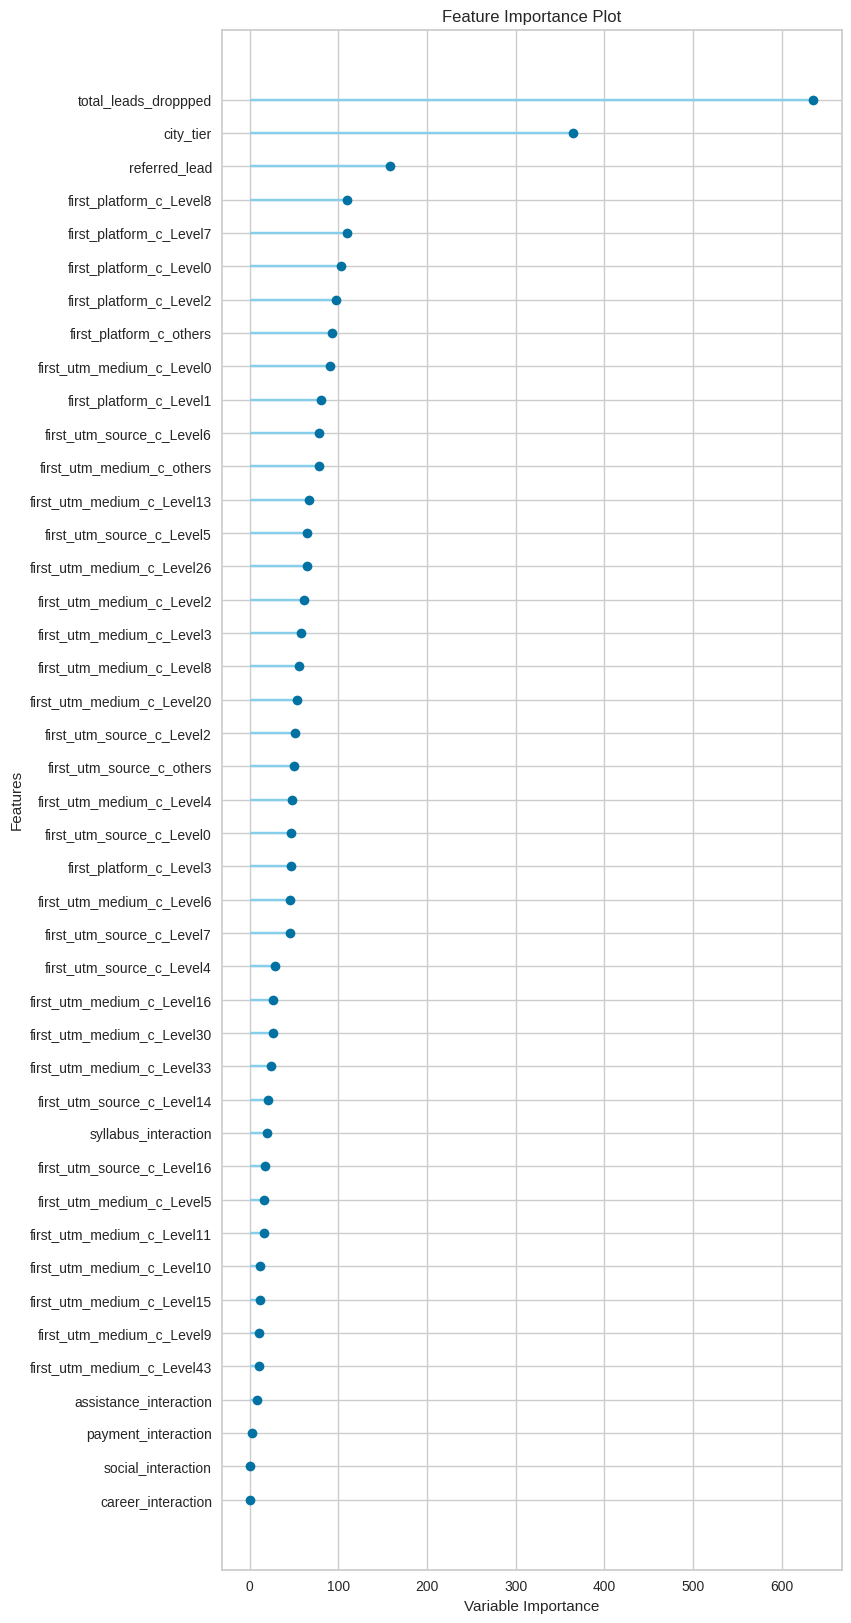

In [44]:
# create feature importance plot
plot_model(final_model, plot='feature_all')

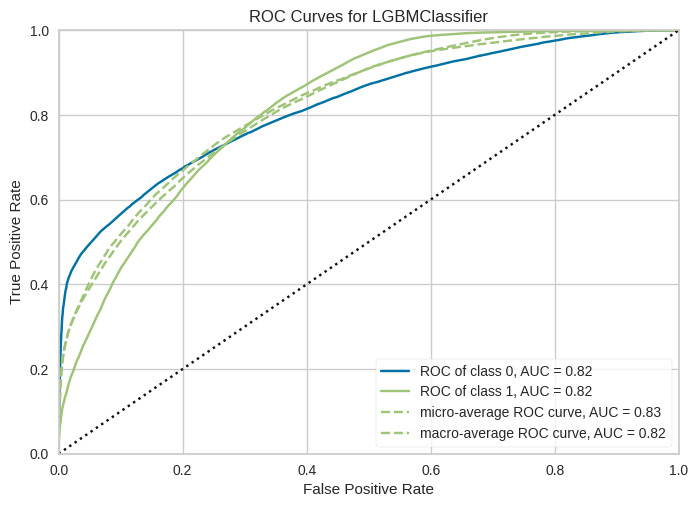

In [38]:
plot_model(final_model, plot = 'auc')


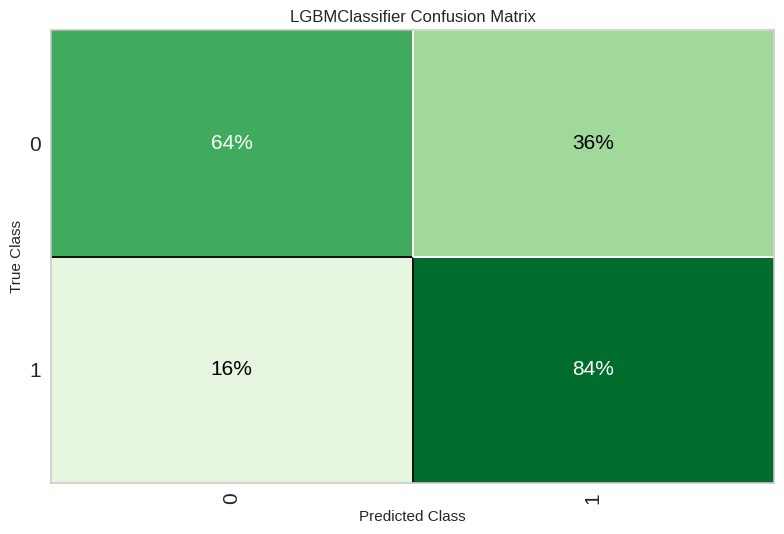

In [41]:
plot_model(final_model, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})


### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [33]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

In [34]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 

In [35]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

In [36]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

In [37]:
# Print the final models configuration so that we can use it in the model retraining pipeline 